In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 36.0 MB/s 
     |████████████████████████████████| 61 kB 507 kB/s 
     |████████████████████████████████| 3.3 MB 40.8 MB/s 
     |████████████████████████████████| 895 kB 22.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# from preprocessing import preprocess
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch import nn, optim
import copy
import random
import sklearn.metrics
import tqdm
import pickle
import pandas as pd
import numpy as np
import math

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
xx = pd.read_pickle("/content/drive/MyDrive/gatech/processed_data_2.pkl")

for i in range(0, len(xx[0])):
  xx[0][i] = tuple(xx[0][i])
for i in range(0, len(xx[1])):
  xx[1][i] = tuple(xx[1][i])

q = set(xx[0] + xx[1])

print(len(q))
q = list(q)

for i in range(0, len(q)):
  q[i] = " ".join(list(q[i]))

508628


In [ ]:
print(q[0])

necessary one renowned coach institute like allen fiitjee get rank within top 100


In [ ]:
class SimilarityModelFineTuneBert(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(SimilarityModelFineTuneBert, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased").cuda()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.feedforward_1 = nn.Linear(768*2, 300).cuda()
        self.non_lin_1 = nn.PReLU().cuda()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.feedforward_2 = nn.Linear(300, 300).cuda()
        self.non_lin_2 = nn.PReLU().cuda()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.feedforward_3 = nn.Linear(300, 2).cuda()
        self.log_softmax = nn.LogSoftmax(dim=0).cuda()

    def forward(self, encoded_input_1, encoded_input_2, train=False):
        if train:
          self.train()
        else:
          self.eval()
        pooler_output_1 = self.bert(encoded_input_1['input_ids'].cuda(), encoded_input_1['attention_mask'].cuda()).last_hidden_state[:, 0].cuda()
        pooler_output_2 = self.bert(encoded_input_2['input_ids'].cuda(), encoded_input_2['attention_mask'].cuda()).last_hidden_state[:, 0].cuda()
        # print(pooler_output_1)
        concatenated_output = torch.cat([pooler_output_1, pooler_output_2], axis=1).cuda()
        f1 = self.dropout(self.non_lin_1(self.feedforward_1(concatenated_output)))
        f2 = self.dropout(self.non_lin_2(self.feedforward_2(f1)))
        return self.log_softmax(self.feedforward_3(f2))

In [ ]:
countr = 0
q_ = []
for i in tqdm(q):
  q_.append(tokenizer(i, return_tensors='pt', is_split_into_words=False, padding=True))
  # countr += 1
  # if(countr == 15):
    # break
print(len(q_))

100%|██████████| 508628/508628 [04:03<00:00, 2093.10it/s]

508628


In [ ]:
model_ = torch.load("/content/drive/MyDrive/gatech/bert-ffn-fine-tune-state-dict.pt")

In [ ]:
model = SimilarityModelFineTuneBert()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(model_)

<All keys matched successfully>

In [ ]:
model.eval()
bert_ = model.bert


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [ ]:
len(q_)

508628

In [ ]:
bert_.eval()
bert_embeddings = []
countr = 0

for i in tqdm(q_):
  
  with torch.no_grad():
    i_embedding = bert_(i['input_ids'].cuda(), i['attention_mask'].cuda()).last_hidden_state[:,0].cpu().numpy()
    bert_embeddings.append(i_embedding)
    # countr += 1
    # if(countr == 10000):
      # break    

100%|██████████| 508628/508628 [59:26<00:00, 142.61it/s]


In [ ]:
bert_embeddings = np.array(bert_embeddings)
bert_embeddings.shape
bert_embeddings = np.squeeze(bert_embeddings)
bert_embeddings.shape

(508628, 768)

In [ ]:
with open("/content/drive/MyDrive/gatech/bert_embeddings_1.pkl", 'wb') as f:
  pickle.dump(bert_embeddings, f)

In [ ]:
nonzero = []
for i in range(0, bert_embeddings.shape[0]):
  # print(bert_embeddings[i].shape)
  # if(bert_embeddings[i].shape[0] != 768):
    # print("Holy")
  nonzero.append(np.count_nonzero(bert_embeddings[i]))
  

  # break


In [ ]:
nonzero.sort()
print(nonzero[:100])

[768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%%time 
# Instantiate the clustering model and visualizer
model = KMeans()
# model = GaussianMixture()
visualizer = KElbowVisualizer(model, k=(200,205))

visualizer.fit(bert_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
n_comp = np.arange(1,5)
bic = []
for j in tqdm(n_comp) :
  gmm = GaussianMixture(n_components=j)
  gmm.fit(bert_embeddings)
  bic.append(gmm.bic(bert_embeddings))



100%|██████████| 4/4 [01:38<00:00, 24.61s/it]


NameError: ignored

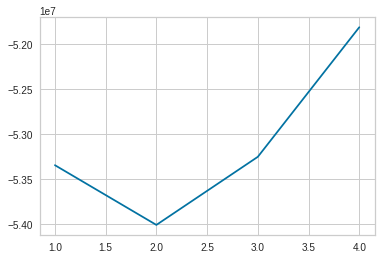

In [ ]:
plt.plot(n_comp,bic)